<a id="top"></a>
## Table of Contents
* [0. Libraries](#0)
* [1. Introduction](#1)
    - [1.1 Motivation](#1.1)
    - [1.2 Project Description](#1.2)
    - [1.3 Milestones](#1.3)
* [2. Data Collection](#2)
    - [2.1 An Overview from the Data](#2.1)
    - [2.2 Data Scraper](#2.2)
* [3. Exploratory Data Analysis](#3) 
    - [3.1 Statistics](#3.1)
    - [3.2 Visualization](#3.2)
    - [3.3 Common Words for Aspects](#3.3)
* [4. Data Module](#4)
    - [4.1 Pre-processing](#4.1)
        - [4.1.1 Data Cleaning](#4.1.1)
        - [4.1.2 GloVe](#4.1.2)
        - [4.1.3 BERT Tokenization](#4.1.3)
    - [4.2 Data Split](#4.2)
* [5. Model Module](#5)
    - [5.1 MLP](#5.1)
    - [5.2 CNN](#5.2)
    - [5.3 RNN](#5.3)
    - [5.4 Transformer](#5.4)
    - [5.5 BERT](#5.5)
* [6. Results](#6)
* [7. Conclusion](#7)

##  0. <a name='0'></a>Libraries
[Back to Table of Contents](#top)

In [21]:
import os
import math
import nltk
import numpy as np
import pandas as pd
import json
import pickle
import collections
import random
import xml.etree.ElementTree as ET
import time
import sklearn.metrics
from sklearn.model_selection import train_test_split
import re
import copy
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')

import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
import seaborn as sns
from IPython import display
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

##  2. <a name='2'></a>Data Collection
[Back to Table of Contents](#top)

In [13]:
# df_1 = pd.read_excel('dataset/TripAdvisor/scrap_data.xlsx')
# df_2 = pd.read_excel('dataset/TripAdvisor/scrap_data_negative.xlsx')
# df = pd.concat([df_1, df_2], ignore_index=True)
df = pd.read_excel('dataset/TripAdvisor/all_scrap_data.xlsx')
print(f'#texts: {len(df)}')
print(df.info())
df.head()

#texts: 9828
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9828 entries, 0 to 9827
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   overall        9828 non-null   int64  
 1   title          9828 non-null   object 
 2   review         9828 non-null   object 
 3   date           9828 non-null   object 
 4   Value          7382 non-null   float64
 5   Location       7383 non-null   float64
 6   Service        9815 non-null   float64
 7   Rooms          7242 non-null   float64
 8   Cleanliness    7307 non-null   float64
 9   Sleep Quality  7186 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 767.9+ KB
None


,overall,title,review,date,Value,Location,Service,Rooms,Cleanliness,Sleep Quality
0,30,Zero customer service experience,Very expensive and no customer service.No rest...,Date of stay: October 2022,10.0,30.0,10.0,30.0,40.0,30.0
1,10,Stay somewhere else,"No customer service! Staff is unavailable, no ...",Date of stay: October 2022,10.0,30.0,10.0,20.0,10.0,30.0
2,10,Awful,No place to eat other than a crowded mini mart...,Date of stay: October 2022,10.0,10.0,10.0,20.0,30.0,10.0
3,20,Would not stay again,For the cost of the room I am sure there are b...,Date of stay: September 2022,10.0,30.0,10.0,30.0,30.0,30.0
4,10,"Old, tired hotel that is not worth the money",I had to stay at this Hyatt to attend UNGA. It...,Date of stay: September 2022,10.0,10.0,10.0,10.0,10.0,10.0


In [14]:
# label mapping
label_map = {10: 0, 20: 0, 30: 1, 40: 2, 50:2} # 0: negative, 1: neutral, 2: positive
cols = [df.columns[0]] + list(df.columns[4:])
for i, col in enumerate(cols):
    df[col] = df[col].map(label_map)
df.fillna(-1, inplace=True)
df.head()

,overall,title,review,date,Value,Location,Service,Rooms,Cleanliness,Sleep Quality
0,1,Zero customer service experience,Very expensive and no customer service.No rest...,Date of stay: October 2022,0.0,1.0,0.0,1.0,2.0,1.0
1,0,Stay somewhere else,"No customer service! Staff is unavailable, no ...",Date of stay: October 2022,0.0,1.0,0.0,0.0,0.0,1.0
2,0,Awful,No place to eat other than a crowded mini mart...,Date of stay: October 2022,0.0,0.0,0.0,0.0,1.0,0.0
3,0,Would not stay again,For the cost of the room I am sure there are b...,Date of stay: September 2022,0.0,1.0,0.0,1.0,1.0,1.0
4,0,"Old, tired hotel that is not worth the money",I had to stay at this Hyatt to attend UNGA. It...,Date of stay: September 2022,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
df.to_csv('dataset/TripAdvisor/cleaned_data.csv')

##  3. <a name='3'></a>Exploratory Data Analysis
[Back to Table of Contents](#top)

In [4]:
temp = []
for i, col in enumerate(df.columns[4:]):
    temp_aspect = df.groupby(col).count()['review'].reset_index()
    temp_aspect.columns = ['label', col]
    if i == 0:
        temp.append(temp_aspect['label'])
    temp.append(temp_aspect[col])
df_aspects = pd.concat(temp, axis=1)
df_aspects

,label,Value,Location,Service,Rooms,Cleanliness,Sleep Quality
0,-1.0,2856,2445,54,3008,2924,3732
1,0.0,2393,836,2803,2361,1869,1491
2,1.0,1234,2231,1353,1027,1089,906
3,2.0,3345,4316,5618,3432,3946,3699


distribution analysis

Average reiview length: 142.13512413512413


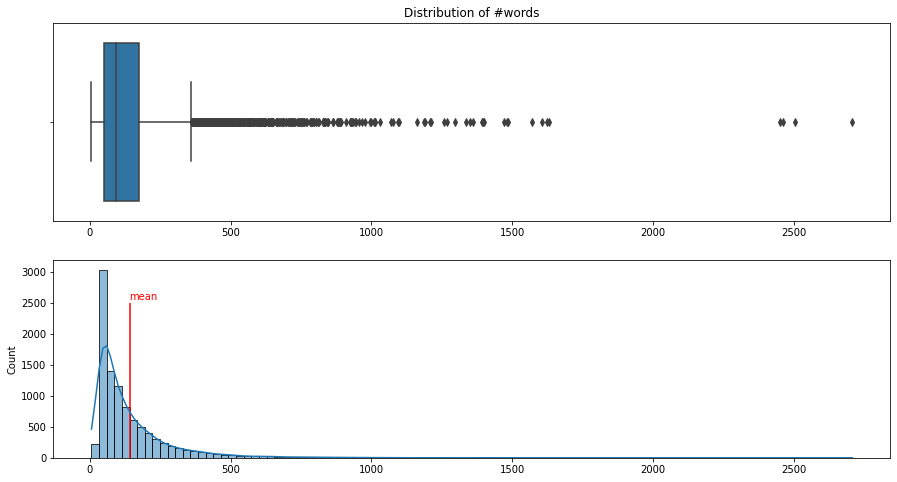

In [68]:
texts = df['review']
text_lens = [len(t.split()) for t in texts.values]
len_mean = np.mean(text_lens)
print(f"Average reiview length: {len_mean}")
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes[0].set_title('Distribution of #words')
sns.boxplot(x=text_lens, ax=axes[0])
sns.histplot(data=text_lens, bins=100, kde=True, ax=axes[1])
axes[1].vlines(len_mean, 0, 2500, color = 'r')
plt.annotate("mean", xy=(len_mean, 2500), xytext=(len_mean-2, 2550), color='r')
plt.show()

length distribution analysis

In [104]:
# top words
tw_aspects = {}
pattern = re.compile('[^\w ]') # used to remove special characters from the string.
for col in cols:
    word_counts = collections.defaultdict(list)
    for text, t in zip(df['review'], df[col]):
        if t == -1: continue
        text = re.sub(pattern, '', text).lower().split()
        text = [word for word in text if word not in stopwords_list]
        word_counts[t].extend(text)
    tw_aspects[col] = (word_counts)

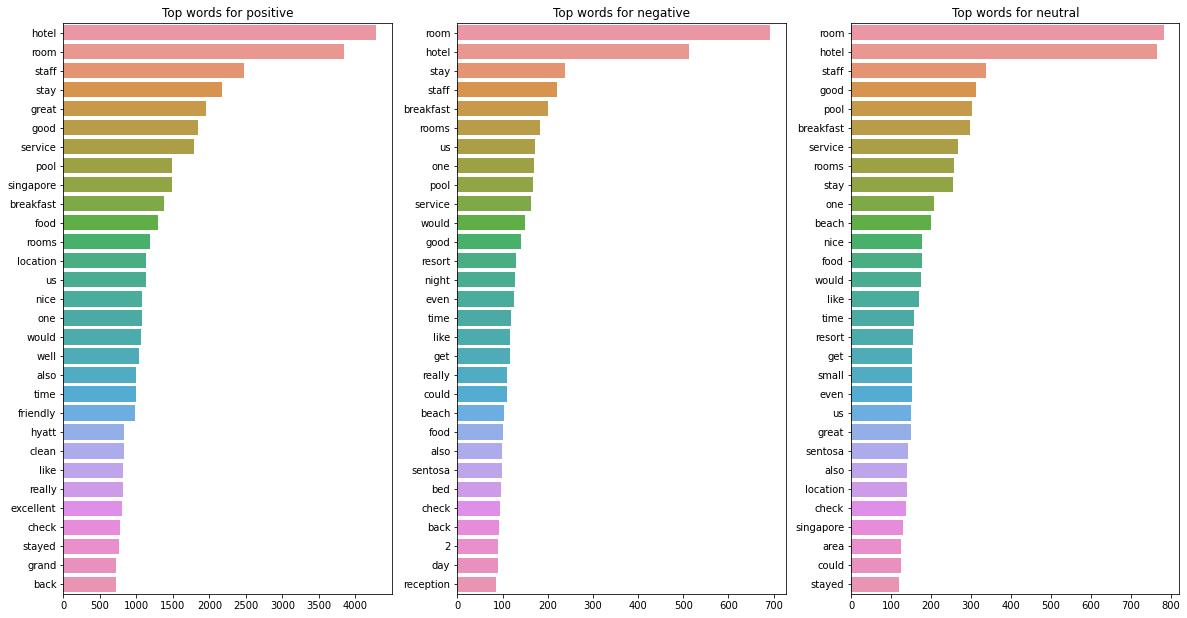

In [129]:
# display top-k topwords for a specific aspect
k = 30
aspect_name = 'Sleep Quality' # 'overall', 'Value', 'Location', 'Service', 'Rooms', 'Cleanliness', 'Sleep Quality'
sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
word_counts = tw_aspects[aspect_name]
fig, axes = plt.subplots(1, 3, figsize=(20,10.5))
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:k]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {sentiment_map[target]}')
plt.show()

aspect-related keywords summary

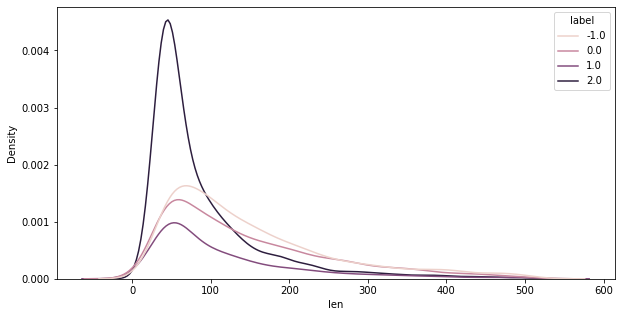

In [67]:
# display length distribution for a specific aspect
aspect_name = 'Value' # 'overall', 'Value', 'Location', 'Service', 'Rooms', 'Cleanliness', 'Sleep Quality'
text_len = collections.defaultdict(list)
pattern = re.compile('[^\w ]')
text_len = pd.DataFrame([len(re.sub(pattern, '', text).lower().split()) for text in df['review']], columns=['len'])
text_len['label'] = df[aspect_name]
text_len = text_len[text_len['len']<512]
plt.figure(figsize=(10, 5))
sns.kdeplot(data=text_len, x='len', hue='label')
plt.show()

##  4. <a name='4'></a>Data Module
[Back to Table of Contents](#top)

In [35]:
df = pd.read_csv("dataset/TripAdvisor/cleaned_data.csv")
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)
df_train, df_dev = train_test_split(df_train, test_size=0.1, random_state=42, shuffle=True)
df_train.to_csv("dataset/TripAdvisor/train.csv", index=False)
df_dev.to_csv("dataset/TripAdvisor/dev.csv", index=False)
df_test.to_csv("dataset/TripAdvisor/test.csv", index=False)
len(df_train), len(df_test), len(df_test)

(7960, 983, 983)

Thanks to https://nlp.stanford.edu/projects/glove/

Here we will use GloVe pretrained corpus model to represent our words with 300 dimensional vectors. 

In [60]:
polar_idx={'negative': 0, 'neutral': 1, 'positive': 2}
aspects_names = {"Value":"value", "Location": "location", "Service":"service", "Rooms": "room", "Cleanliness": "clean", "Sleep Quality": "sleep"}

def parse_Dataset(data_dir, mode):
    """read data from xml file"""
    df = pd.read_csv(os.path.join(data_dir, mode + '.csv'))
    corpus=[]
    label_cnt= np.zeros(len(polar_idx))
    for i, row in df.iterrows():
        text_id = row["id"]
        text = row["review"]
        for j, aspect in enumerate(aspects_names.keys()):
            label = int(row[aspect])
            if label == -1: continue
            corpus += [{"id": str(text_id) + '_' + str(j), "text": text, "aspect": aspects_names[aspect], "polarity": label}]
            label_cnt[label] += 1

    print(f"distribution of [negative, neutral, positive]: {label_cnt}")
    print(f"ratio: [{label_cnt[0]/sum(label_cnt)*100 :.1f}%, {label_cnt[1]/sum(label_cnt)*100 :.1f}%, {label_cnt[2]/sum(label_cnt)*100 :.1f}%]")
    print(f"#examples: {len(corpus)}")
    return corpus

print("Load traning corpus:")
train_corpus=parse_Dataset('dataset/TripAdvisor', 'train')
with open("dataset/TripAdvisor/train.json", "w") as fw:
    json.dump({line["id"]: line for line in train_corpus}, fw, sort_keys=True, indent=4)
    
print("Load development corpus:")
dev_corpus=parse_Dataset("dataset/TripAdvisor", "dev")
with open("dataset/TripAdvisor/dev.json", "w") as fw:
    json.dump({line["id"]: line for line in dev_corpus}, fw, sort_keys=True, indent=4)
    
print("Load testing corpus:")
test_corpus=parse_Dataset("dataset/TripAdvisor", "test")
with open("dataset/TripAdvisor/test.json", "w") as fw:
    json.dump({line["id"]: line for line in test_corpus}, fw, sort_keys=True, indent=4)

Load traning corpus:
distribution of [negative, neutral, positive]: [ 9533.  6363. 19715.]
ratio: [26.8%, 17.9%, 55.4%]
#examples: 35611
Load development corpus:
distribution of [negative, neutral, positive]: [1004.  678. 2247.]
ratio: [25.6%, 17.3%, 57.2%]
#examples: 3929
Load testing corpus:
distribution of [negative, neutral, positive]: [1216.  799. 2394.]
ratio: [27.6%, 18.1%, 54.3%]
#examples: 4409


In [61]:
valid_split=150
polar_idx={'negative': 0, 'neutral': 1, 'positive': 2}
aspects_names = {"food": "food","service": "service", "price": "price", "ambience": "ambience", "anecdotes/miscellaneous": "miscellaneous"}

def parse_SemEval14(fn):
    """read data from xml file"""
    root=ET.parse(fn).getroot()
    corpus=[]
    opin_cnt=[0]*len(polar_idx)
    for sent in root.iter("sentence"):
        opins=set()
        for opin in sent.iter('aspectCategory'):
            if opin.attrib['category']!="NULL":
                if opin.attrib['category'] in aspects_names.keys() and opin.attrib['polarity'] in polar_idx:
                    opins.add((aspects_names[opin.attrib['category']], opin.attrib['polarity']))
        for idx, opin in enumerate(opins):
            opin_cnt[polar_idx[opin[-1]]]+=1
            corpus.append({"id": sent.attrib['id']+"_"+str(idx), "sentence": sent.find('text').text, "aspect": opin[0], "polarity": opin[-1]})
    print(f"distribution of [negative, neutral, positive]: {opin_cnt}")
    print(f"#examples: {len(corpus)}")
    return corpus

print("Load traning corpus:")
train_corpus=parse_SemEval14('dataset/SemEval14/Restaurants_Train_v2.xml')
with open("dataset/SemEval14/train.json", "w") as fw:
    json.dump({rec["id"]: rec for rec in train_corpus[:-valid_split] }, fw, sort_keys=True, indent=4)
with open("dataset/SemEval14/dev.json", "w") as fw:
    json.dump({rec["id"]: rec for rec in train_corpus[-valid_split:] }, fw, sort_keys=True, indent=4)
print("Load testing corpus:")
test_corpus=parse_SemEval14('dataset/SemEval14/Restaurants_Test_Gold.xml')
with open("dataset/SemEval14/test.json", "w") as fw:
    json.dump({rec["id"]: rec for rec in test_corpus}, fw, sort_keys=True, indent=4)

Load traning corpus:
distribution of [negative, neutral, positive]: [839, 500, 2177]
#examples: 3516
Load testing corpus:
distribution of [negative, neutral, positive]: [222, 94, 657]
#examples: 973


In [62]:
# data_utils
class Tokenizer(object):
    """Construct a tokenizer."""
    def __init__(self, max_seq_len=math.inf, lower=True):
        self.lower = lower
        self.max_seq_len = max_seq_len
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 1

    def fit_on_text(self, text): # build word-id mapping
        if self.lower:
            text = text.lower()
        words = text.split()
        for word in words:
            if word not in self.word2idx:
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.idx += 1

    def convert_tokens_to_ids(self, text, padding='post', truncating='post'): # convert input into ids
        if self.lower:
            text = text.lower()
        words = text.split()
        unknownidx = len(self.word2idx)+1
        sequence = [self.word2idx[w] if w in self.word2idx else unknownidx for w in words]
        if len(sequence) == 0:
            sequence = [0]
        return pad_and_truncate(sequence, self.max_seq_len, padding=padding, truncating=truncating)
    
def build_tokenizer(all_examples, aspects, max_seq_len, dat_fname):
    """Build tokenizer (word-id pair) for dataset"""
    if os.path.exists(dat_fname):
        print('loading tokenizer:', dat_fname)
        tokenizer = pickle.load(open(dat_fname, 'rb'))
    else:
        length_dict = collections.defaultdict(list)
        corpus = ""
        for i, examples in enumerate(all_examples):
            for example in examples:
                words = nltk.word_tokenize(example.text)
                length_dict[i].append(len(words))
                for word in words:
                    corpus += (word + " ")
        for aspect in aspects:
            corpus += (aspect + " ")

        tokenizer = Tokenizer(max_seq_len)
        tokenizer.fit_on_text(corpus)
        pickle.dump(tokenizer, open(dat_fname, 'wb'))
        
        plt.figure()
        plt.hist([length_dict[0] + length_dict[1] + length_dict[2]], bins=range(0, 100, 10))
        print(f'max_length = {max(max(length_dict[0]), max(length_dict[1]), max(length_dict[2]))}')
        print(f'avg_length = {(sum(length_dict[0])+sum(length_dict[1])+sum(length_dict[2]))/(len(length_dict[0])+len(length_dict[1])+len(length_dict[2])) :.2f}')
    return tokenizer

def build_glove_embeddings(word2idx, dat_fname):
    """Build vocabulary for dataset"""
    if os.path.exists(dat_fname):
        print('Loading embedding_matrix:', dat_fname)
        embedding_matrix = pickle.load(open(dat_fname, 'rb'))
    else:
        print('Loading word vectors')
        embedding_matrix = np.zeros((len(word2idx) + 2, 300))  # idx 0 and len(word2idx)+1 are all-zeros
        embedding_dict={}
        with open('dataset/glove.42B.300d.txt','r') as f:
            for line in f:
                values=line.split()
                word = values[0]
                vectors=np.asarray(values[1:],'float32')
                embedding_dict[word]=vectors
                
        print('Building embedding_matrix:', dat_fname)
        for word, i in word2idx.items():
            vec = embedding_dict.get(word)
            if vec is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = vec
        pickle.dump(embedding_matrix, open(dat_fname, 'wb'))
    return embedding_matrix

def pad_and_truncate(sequence, maxlen, dtype='int64', padding='post', truncating='post', value=0):
    """Pad or/and truncate the input sequence"""
    x = (np.ones(maxlen) * value).astype(dtype)
    if truncating == 'pre':
        trunc = sequence[-maxlen:]
    else:
        trunc = sequence[:maxlen]
    trunc = np.asarray(trunc, dtype=dtype)
    if padding == 'post':
        x[:len(trunc)] = trunc
    else:
        x[-len(trunc):] = trunc
    return x

In [63]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, unique_id, aspect, text, label):
        """Constructs a InputExample.
        Args:
            unique_id (string): 
                Unique id for the example.
            aspect (string): 
                Aspect category name.
            text (string): 
                Text or text span.
            label (string): 
                The label of the example. 
        Returns: 
        
        """
        self.unique_id = unique_id
        self.aspect = aspect
        self.text = text
        self.label = label

        
class ABSCProcessor(object):
    """Processor for the Aspect-based Sentiment Classification."""
    def __init__(self, data_dir, name):
        self.data_path = os.path.join(data_dir, name)
        self.name = name
        
    def get_examples(self, mode):
        """Read data from json file.
        Args:
            data_dir (string):
                Path.
            mode (string): 
                Indicate train/dev/test.
        Returns: 
            examples for different modes.
        """
        return self._create_examples(self._read_json(os.path.join(self.data_path, mode+".json")))
    
    def get_aspects(self):
        """Return aspects for specific dataset"""
        if self.name == "SemEval14":
            return ["food", "service", "price", "ambience", "miscellaneous"]
        elif self.name == "TripAdvisor":
            return ["value", "location", "service", "room", "clean", "sleep"]
        
    def get_labels(self):
        """Return labels for specific dataset"""
        return ["negative", "neutral", "positive"]
    
    def _create_examples(self, lines):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, key) in enumerate(lines):
            unique_id = key
            aspect = lines[key]['aspect']
            if self.name == "SemEval14":
                text = lines[key]['sentence']
            elif self.name == "TripAdvisor":
                text = lines[key]['text']
            label = lines[key]['polarity']
            examples.append(InputExample(unique_id=unique_id, aspect=aspect, text=text, label=label))
        return examples  
    
    def _read_json(cls, input_file):
        """Reads a json file for tasks in sentiment analysis."""
        with open(input_file) as f:
            return json.load(f)

In [73]:
class ABSCDataset(Dataset):
    """Build dataset and convert examples to features"""
    def __init__(self, name, examples, tokenizer):
        self.name = name
        self.examples = examples
        self.tokenizer = tokenizer
        self.convert_data_to_features()
    
    def convert_data_to_features(self):
        """convert examples to features"""
        if self.name == "SemEval14":
            label_map = {"negative": 0, "neutral": 1, "positive": 2}
            aspect_map = {"food": 0,"service": 1, "price": 2, "ambience": 3, "miscellaneous": 4}
        elif self.name == "TripAdvisor":
            label_map = {0: 0, 1: 1, 2: 2}
            aspect_map = {"value":0, "location":1, "service":2, "room":3, "clean":4, "sleep":5}

        output = []
        for (i, example) in enumerate(tqdm(self.examples)):
            input_ids = self.tokenizer.convert_tokens_to_ids(example.text)
            aspect_token_id = self.tokenizer.word2idx[example.aspect]
            aspect_id = aspect_map[example.aspect]
            label_id = label_map[example.label]
            
            feature = {
                "input_ids": input_ids,
                "aspect_token_id": aspect_token_id,
                "aspect_id": aspect_id,
                "label_id": label_id
            }
            output += [feature]
        self.data = output
        
    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [74]:
print("Processing the Dataset")
data_dir="dataset"
data_name = "TripAdvisor"
datset_path = os.path.join(data_dir, data_name)
processor = ABSCProcessor(data_dir, data_name)
aspects = processor.get_aspects()
num_classes = len(processor.get_labels())
train_examples = processor.get_examples("train")
dev_examples = processor.get_examples("dev")
test_examples = processor.get_examples("test")

max_seq_len = 500
tokenizer = build_tokenizer(all_examples = [train_examples, dev_examples, test_examples], 
                            aspects = aspects, 
                            max_seq_len = max_seq_len,
                            dat_fname = datset_path+'/tokenizer_{0}.dat'.format(max_seq_len))

embedding_matrix = build_glove_embeddings(
                word2idx = tokenizer.word2idx,
                dat_fname = datset_path+'/glove_300d_embeddings.dat')

train_data = ABSCDataset(data_name, train_examples, tokenizer)
dev_data = ABSCDataset(data_name, dev_examples, tokenizer)
test_data = ABSCDataset(data_name, test_examples, tokenizer)

Processing the Dataset
loading tokenizer: dataset/TripAdvisor/tokenizer_500.dat
Loading embedding_matrix: dataset/TripAdvisor/glove_300d_embeddings.dat


  0%|          | 0/35611 [00:00<?, ?it/s]

  0%|          | 0/3929 [00:00<?, ?it/s]

  0%|          | 0/4409 [00:00<?, ?it/s]

##  5. <a name='5'></a>Model Module
[Back to Table of Contents](#top)

In [75]:
# utils
# reference: https://github.com/d2l-ai/d2l-en
def try_gpu(i=0):  #@save
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():  #@save
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_utils`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats('svg')

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
    def save(self, output_dir, fname):
        plt.savefig(os.path.join(output_dir, fname), dpi=600)

class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`sec_minibatch_sgd`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [76]:
def accuracy(y_pred, y):
    """Compute the number of correct predictions.
    Defined in :numref:`sec_utils`"""
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = torch.argmax(y_pred, axis=1)
    cmp = (y_pred.type(y.dtype)) == y
    return float(torch.sum(cmp.type(y.dtype)))

def evaluate_loss_and_acc_gpu(net, data_iter, loss=None, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    if loss:
        metric = Accumulator(3)
    else:
        metric = Accumulator(2)
    
    with torch.no_grad():
        for batch in data_iter:
            if isinstance(batch, dict):
                for k, v in batch.items():
                    batch[k] = batch[k].to(device)
            else:
                batch = batch.to(device)
            y = batch['label_id']
            y_pred = net(**batch)
            if loss:
                metric.add(loss(y_pred, y).sum(), accuracy(y_pred, y), torch.numel(y))
            else:
                metric.add(accuracy(y_pred, y), torch.numel(y))
    return (metric[0] / metric[2], metric[1] / metric[2]) if loss else metric[0] / metric[1]

def test(net, data_iter, output_dir=None, device=None):
    net.eval()
    full_logits=[]
    full_label_ids=[]
    for i, batch in enumerate(data_iter):
        with torch.no_grad():
            if isinstance(batch, dict):
                for k, v in batch.items():
                    batch[k] = batch[k].to(devices[0])
            else:
                batch = batch.to(device)
            
            logits = net(**batch)
            logits = logits.detach().cpu().numpy()
            y = batch['label_id'].cpu().numpy()

            full_logits.extend(logits.tolist())
            full_label_ids.extend(y.tolist())
    
    
    y_pred = [np.argmax(logit) for logit in full_logits]
    y_true = full_label_ids
    f1 =sklearn.metrics.f1_score(y_true, y_pred, average='macro')
    acc =sklearn.metrics.accuracy_score(y_true, y_pred)
    print(f"acc: {acc*100 :.2f}, f1-macro: {f1*100 :.2f}")
    if output_dir:
        output_eval_json = os.path.join(output_dir, str(net.__class__.__name__) + "_predictions.json") 
        with open(output_eval_json, "w") as fw:
            json.dump({"logits": full_logits, "label_ids": full_label_ids}, fw)
            
def test_on_checkpoint(net, file_path, data_iter, output_dir=None, device=None):
    state_dict = torch.load(file_path, map_location=device)
    new_state_dict = collections.OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    net.load_state_dict(new_state_dict)
    net.to(device)
    net.eval()
    full_logits=[]
    full_label_ids=[]
    for i, batch in enumerate(data_iter):
        with torch.no_grad():
            if isinstance(batch, dict):
                for k, v in batch.items():
                    batch[k] = batch[k].to(devices[0])
            else:
                batch = batch.to(device)
            
            logits = net(**batch)
            logits = logits.detach().cpu().numpy()
            y = batch['label_id'].cpu().numpy()

            full_logits.extend(logits.tolist())
            full_label_ids.extend(y.tolist())
    
    
    y_pred = [np.argmax(logit) for logit in full_logits]
    y_true = full_label_ids
    f1 =sklearn.metrics.f1_score(y_true, y_pred, average='macro')
    acc =sklearn.metrics.accuracy_score(y_true, y_pred)
    print(f"checkpoint:{file_path} - acc: {acc*100 :.2f}, f1-macro: {f1*100 :.2f}")
    if output_dir:
        output_eval_json = os.path.join(output_dir, str(net.__class__.__name__) + "_predictions.json") 
        with open(output_eval_json, "w") as fw:
            json.dump({"logits": full_logits, "label_ids": full_label_ids}, fw)

In [77]:
def train_batch(net, batch, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs"""
    if isinstance(batch, dict):
        for k, v in batch.items():
            batch[k] = batch[k].to(devices[0])
    else:
        batch = batch.to(devices[0])
    y = batch['label_id']
    net.train()
    trainer.zero_grad()
    pred = net(**batch)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train(net, train_iter, valid_iter, num_epochs, optimizer, lr, wd, lr_period, lr_decay, devices):
    if optimizer == 'sgd':
        trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    elif optimizer == 'adam':
        trainer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    elif optimizer == 'adamw':
        trainer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=wd)
        
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    
    loss = nn.CrossEntropyLoss(reduction="none")
    timer = Timer()
    num_batches = len(train_iter)
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend += ['valid loss', 'valid acc']
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend, figsize=(7, 5))
    
    monitor_val = math.inf
    model_name = str(net.__class__.__name__)
        
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = Accumulator(4)
        for i, batch in enumerate(train_iter):
            timer.start()
            labels = batch['label_id']
            output = train_batch(net, batch, loss, trainer, devices)
            metric.add(output[0], output[1], labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2], None, None))
        if valid_iter is not None:
            valid_loss, valid_acc = evaluate_loss_and_acc_gpu(net, valid_iter, loss, devices[0])
            animator.add(epoch + 1, (None, None, valid_loss, valid_acc))
            if valid_loss < monitor_val:
                filename = model_name + f"-epoch{epoch}-val_loss{valid_loss :.2f}.pt"
                best_model_state = copy.deepcopy(net.state_dict())
                monitor_val = valid_loss
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')
    args.pt_path = os.path.join("checkpoints", filename)
    torch.save(best_model_state, args.pt_path)
    animator.save("output", model_name + f"-train_loss{metric[0] / metric[2]:.2f}.png")

###  5.1 <a name='5.1'></a>MLP
[Back to Table of Contents](#top)

In [79]:
class MLPs(nn.Module):
    """ Build specific multi-layer perceptron for each aspect"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_aspects, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.output_dim=output_dim
        self.num_aspects = num_aspects
        self.MLP_list = nn.ModuleList()
        for _ in range(self.num_aspects):
            layer = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, output_dim))
            self.MLP_list.append(layer)

    def forward(self, input_ids, aspect_id, **kwarg):
        x = self.embedding(input_ids) # [batch_size, seq_length, hidden_dim]
        x = x.mean(dim=1) # [batch_size, hidden_dim]
        output = torch.zeros((input_ids.shape[0], self.output_dim), dtype=x.dtype, device=x.device)
        for i, aspect_idx in enumerate(aspect_id):
            layer = self.MLP_list[aspect_idx]
            output[i] = layer(x[i].unsqueeze(0))
        return output # [batch_size, output_dim]
    
class MLP(nn.Module):
    """ Simple multi-layer perceptron (also called FFN) for all aspects"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, input_ids, aspect_token_id, **kwarg):
        input_x = self.embedding(input_ids) # [batch_size, seq_length, hidden_dim]
        aspect_x = self.embedding(aspect_token_id)  # [batch_size, hidden_dim]
        x = torch.cat((input_x, aspect_x.unsqueeze(1)), dim=1) # [batch_size, seq_length+1, hidden_dim]
        x = x.mean(dim=1) # [batch_size, hidden_dim]
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < (self.num_layers - 1) else layer(x)
        return x # [batch_size, output_dim]
    
class MLPv2(nn.Module):
    """ Simple multi-layer perceptron (also called FFN) for all aspects"""
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))
        self.linear_proj = nn.Linear(hidden_dim*2, hidden_dim)

    def forward(self, input_ids, aspect_token_id, **kwarg):
        input_x = self.embedding(input_ids) # [batch_size, seq_length, hidden_dim]
        aspect_x = self.embedding(aspect_token_id)  # [batch_size, hidden_dim]
        x = torch.cat((input_x.mean(dim=1), aspect_x), dim=-1) # [batch_size, 2*hidden_dim]
        x = F.relu(self.linear_proj(x)) # [batch_size, hidden_dim]
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < (self.num_layers - 1) else layer(x)
        return x # [batch_size, output_dim]

In [82]:
class Args(object):
    def __init__(self):
        super().__init__()
        self.optimizer = 'adam'
        self.batch_size = 16
        self.num_epochs = 30
        self.lr = 1e-3
        self.weight_decay = 1e-4
        self.lr_period = 4
        self.lr_decay = 0.9
        self.dropout = 0.1
        self.embedding_dim = 300
        self.hidden_dim = 300
        self.num_class = 3
        self.num_aspect = 6
        self.pt_path = ''
        
args = Args()
train_iter = DataLoader(dataset=train_data, batch_size = args.batch_size, shuffle=True)
dev_iter = DataLoader(dataset=dev_data, batch_size = args.batch_size, shuffle=False)
test_iter = DataLoader(dataset=test_data, batch_size=1, shuffle=False)
devices= try_all_gpus()

train loss 0.481, train acc 0.800, valid loss 0.530, valid acc 0.779
1200.9 examples/sec on [device(type='cpu')]


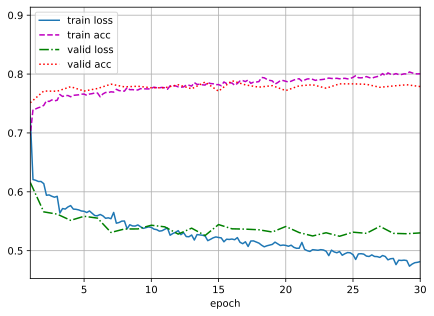

In [83]:
net = MLPs(args.embedding_dim, args.hidden_dim, args.num_class, args.num_aspect, embedding_matrix)
train(net, train_iter, dev_iter, 
      args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.lr_period, args.lr_decay, devices)

In [84]:
test(net, test_iter, "output")
test_on_checkpoint(net, args.pt_path, test_iter, "output")

acc: 77.48, f1-macro: 67.92
checkpoint:checkpoints/MLPs-epoch23-val_loss0.52.pt - acc: 77.98, f1-macro: 69.07


train loss 0.508, train acc 0.787, valid loss 0.560, valid acc 0.756
2366.4 examples/sec on [device(type='cpu')]


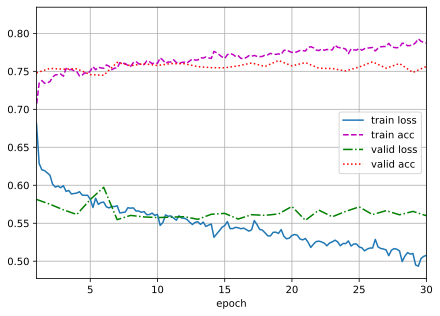

In [85]:
net = MLP(args.embedding_dim, args.hidden_dim, args.num_class, 2, embedding_matrix)
train(net, train_iter, dev_iter, args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.lr_period, args.lr_decay, devices)

In [86]:
test(net, test_iter, "output")
test_on_checkpoint(net, args.pt_path, test_iter, "output")

acc: 74.73, f1-macro: 64.12
checkpoint:checkpoints/MLP-epoch20-val_loss0.55.pt - acc: 75.16, f1-macro: 61.18


In [ ]:
net = MLPv2(args.embedding_dim, args.hidden_dim, args.num_class, 2, embedding_matrix)
train(net, train_iter, dev_iter, 
      args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.lr_period, args.lr_decay, devices)

####  5.1.1 <a name='5.1.1'></a>MLP For SemEval
[Back to MLP](#5.1)

train loss 0.472, train acc 0.811, valid loss 0.841, valid acc 0.633
5304.1 examples/sec on [device(type='cpu')]


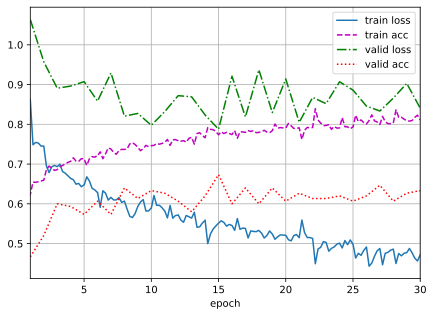

In [212]:
net = MLP(args.embedding_dim, args.hidden_dim, args.num_class, 2, embedding_matrix)
train(net, train_iter, dev_iter, args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.lr_period, args.lr_decay, devices)

In [215]:
test(net, test_iter, "output")
test_on_checkpoint(net, args.pt_path, test_iter, "output")

acc: 76.67, f1-macro: 62.97
checkpoint:checkpoints/MLP-epoch14-val_loss0.79.pt - acc: 75.75, f1-macro: 64.24


train loss 0.608, train acc 0.740, valid loss 0.985, valid acc 0.573
2609.6 examples/sec on [device(type='cpu')]


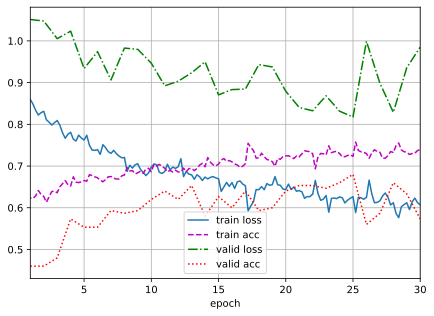

In [217]:
net = MLPv2(args.embedding_dim, args.hidden_dim, args.num_class, 2, embedding_matrix)
train(net, train_iter, dev_iter, 
      args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.lr_period, args.lr_decay, devices)

In [218]:
test(net, test_iter, "output")
test_on_checkpoint(net, args.pt_path, test_iter, "output")

acc: 75.95, f1-macro: 57.89
checkpoint:checkpoints/MLPv2-epoch24-val_loss0.82.pt - acc: 71.84, f1-macro: 61.34


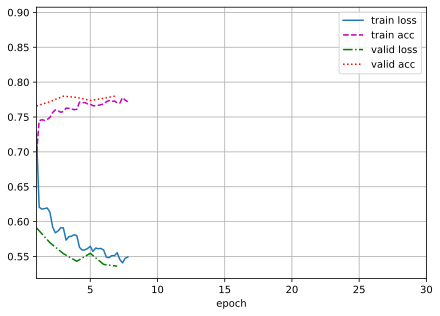

In [ ]:
net = MLPs(args.embedding_dim, args.hidden_dim, args.num_class, args.num_aspect, embedding_matrix)
train(net, train_iter, dev_iter, 
      args.num_epochs, args.optimizer, args.lr, args.weight_decay, args.lr_period, args.lr_decay, devices)

In [220]:
test(net, test_iter, "output")
test_on_checkpoint(net, args.pt_path, test_iter, "output")

acc: 74.72, f1-macro: 61.65
checkpoint:checkpoints/MLPs-epoch8-val_loss0.82.pt - acc: 74.61, f1-macro: 60.83
